In [7]:
import tensorflow as tf
import numpy as np
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


data_dir = '/kaggle/input/preprocessed-images'
file_paths = []
labels = []

for class_name in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, img_file))
            labels.append(class_name)

file_paths = np.array(file_paths)
labels = np.array(labels)


le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
y_categorical = to_categorical(labels_encoded, num_classes=23)

def load_and_preprocess_images(file_paths, target_size=(128, 128)):
    images = []
    for img_path in file_paths:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

X_images = load_and_preprocess_images(file_paths)

X_train, X_test, y_train, y_test = train_test_split(
    X_images, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42
)

tr_size = math.ceil(len(X_train) / 3)
ts_size = math.ceil(len(X_test) / 3)


def create_model():
  
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(23, activation='softmax')(x)  

    model=Model(inputs=base_model.input, outputs=x)
    return model

global_model = create_model()

start = 0
startindex = 0
lastindex = tr_size
end = ts_size
X_values = {}
y_values = {}
X_test_values = {}
y_test_values = {}
local_models = {}
weights = {}
for j in range(3):
    X_values[j], y_values[j] = X_train[startindex:lastindex], y_train[startindex:lastindex]
    X_test_values[j], y_test_values[j] = X_test[start:end], y_test[start:end]
    
    startindex = lastindex
    lastindex += tr_size
    start = end
    end += ts_size
    
    local_models[j] = create_model() 
    local_models[j].compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    print(f"Training client {j+1} model...")
    local_models[j].fit(
        X_values[j], y_values[j],
        validation_data=(X_test_values[j], y_test_values[j]),
        epochs=1,
        batch_size=32,
    )
    
    weights[j] = local_models[j].get_weights()

print("All clients trained successfully!")


Training client 1 model...


I0000 00:00:1745425683.301830      95 service.cc:148] XLA service 0x7f4a0c00e810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745425683.302417      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745425683.302439      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745425683.618732      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/130 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.1406 - loss: 3.6573 

I0000 00:00:1745425693.188614      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 39s 208ms/step - accuracy: 0.1216 - loss: 3.1459 - val_accuracy: 0.2042 - val_loss: 2.6897
Training client 2 model...
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.1331 - loss: 3.0867 - val_accuracy: 0.2235 - val_loss: 2.6661
Training client 3 model...
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - accuracy: 0.1225 - loss: 3.1542 - val_accuracy: 0.2249 - val_loss: 2.7094
All clients trained successfully!


In [9]:
weights_total={}
avg_weights={}
for n in range(0,30): 
     weights_total[n]=[]
     temp=[]
     for j in range(0,3):
         temp.append(weights[j][n])
     weights_total[n]=temp
for n in range(0,30):
     avg_weights[n]=np.average(weights_total[n],axis=0)
ls_avg_wt = []
for n in range(0,30):
    ls_avg_wt.append(avg_weights[n])
global_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
global_model.set_weights(ls_avg_wt)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping

loss = []
acc = []
ls_avg_wt = global_model.get_weights()
for t in range(15):
    weights_total = {}
    avg_weights = {}
    weights = {}

    for j in range(3):
        local_models[j].set_weights(ls_avg_wt)
        local_models[j].fit(X_values[j], y_values[j], validation_data=(X_test_values[j], y_test_values[j]), epochs=15)
        weights[j] = local_models[j].get_weights()

    for n in range(len(weights[0])):  
        weights_total[n] = [weights[j][n] for j in range(3)]
        avg_weights[n] = np.average(weights_total[n], axis=0)

    ls_avg_wt = [avg_weights[n] for n in range(len(avg_weights))]
    global_model.set_weights(ls_avg_wt)

    result = global_model.evaluate(X_test, y_test)
    loss.append(result[0])
    acc.append(result[1])


Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.1785 - loss: 2.8996 - val_accuracy: 0.2457 - val_loss: 2.6285
Epoch 2/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.2412 - loss: 2.5965 - val_accuracy: 0.2842 - val_loss: 2.5296
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.2973 - loss: 2.4591 - val_accuracy: 0.3044 - val_loss: 2.4531
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.3161 - loss: 2.3295 - val_accuracy: 0.3035 - val_loss: 2.4187
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.3829 - loss: 2.1429 - val_accuracy: 0.3198 - val_loss: 2.3716
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.4019 - loss: 2.0685 - val_accuracy: 0.3295 - val_loss: 2.3398
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.4582 - loss: 1.9304 - val_accuracy: 0.3218 - val_loss: 2.3341
Epoch 8/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.4864 - loss: 1.7937 -

In [11]:
acc

[0.3550771176815033,
 0.38849613070487976,
 0.3946015536785126,
 0.40713366866111755,
 0.4042416512966156,
 0.4135604202747345,
 0.410347044467926,
 0.4135604202747345,
 0.40938302874565125,
 0.4074550271034241,
 0.4135604202747345,
 0.4090617001056671,
 0.4074550271034241,
 0.40584832429885864,
 0.40938302874565125]

98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step


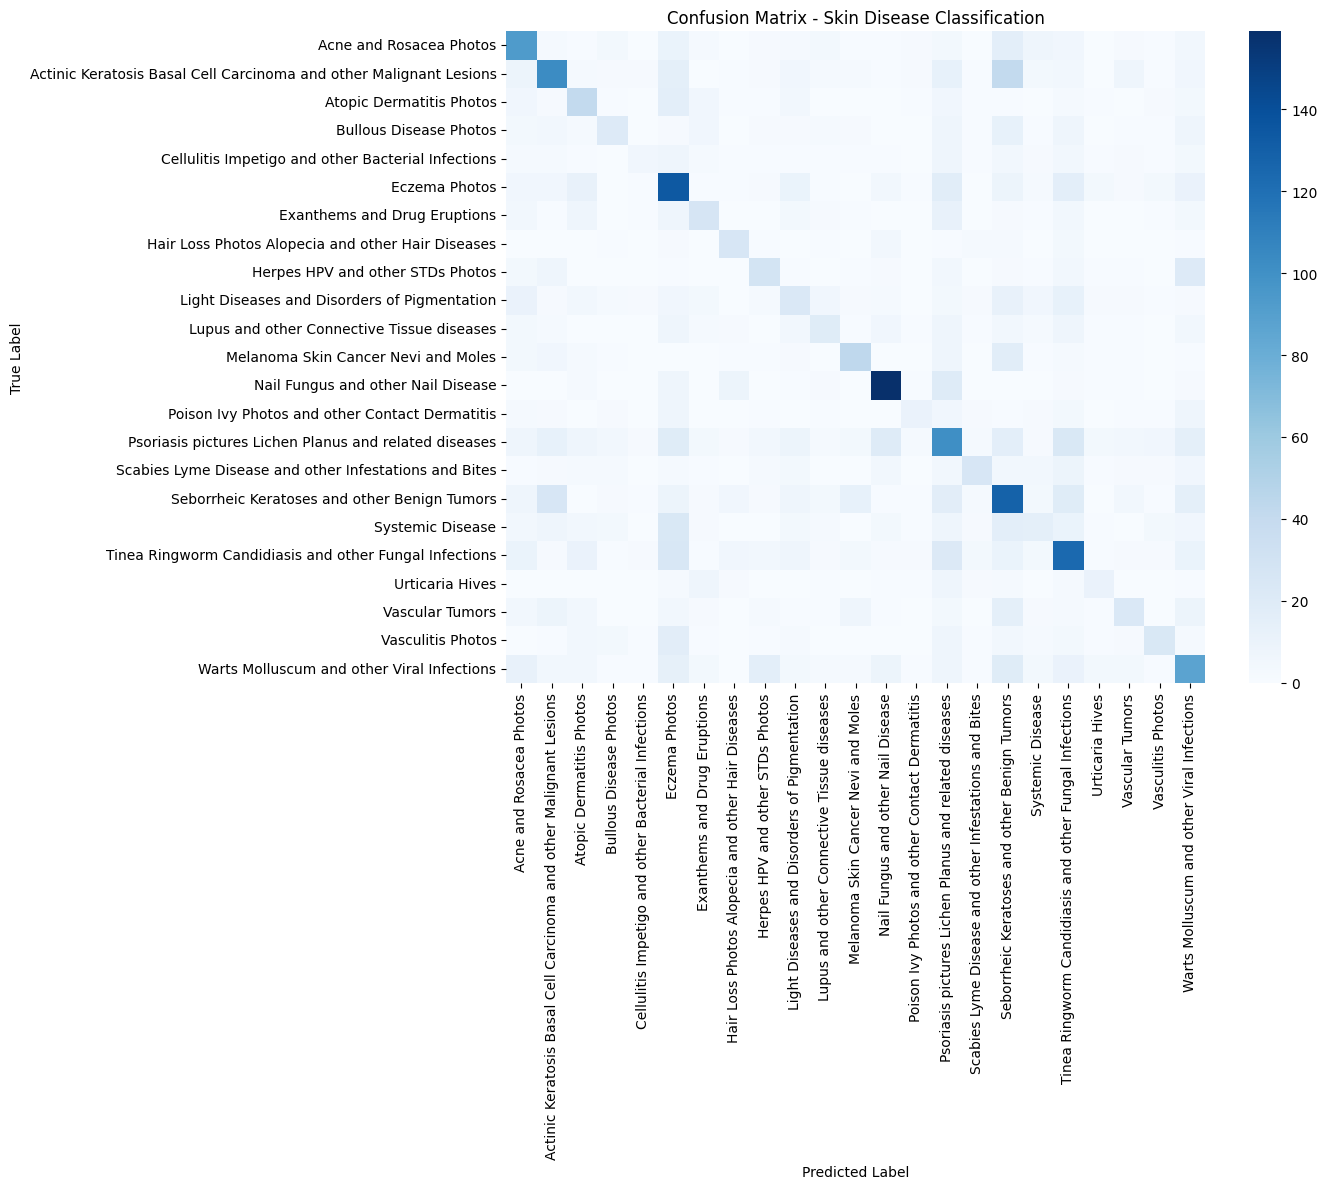

Classification Report:

                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.46      0.55      0.50       168
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.50      0.45      0.47       230
                                          Atopic Dermatitis Photos       0.34      0.42      0.37        98
                                            Bullous Disease Photos       0.38      0.23      0.29        90
                Cellulitis Impetigo and other Bacterial Infections       0.32      0.10      0.16        58
                                                     Eczema Photos       0.39      0.54      0.46       247
                                      Exanthems and Drug Eruptions       0.35      0.33      0.34        81
                 Hair Loss Photos Alopecia and other Hair Diseases       0.45      0.54      0.49        48
   

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_prob = global_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Skin Disease Classification')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {accuracy:.4f}")


In [2]:
import tensorflow as tf
import numpy as np
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load dataset paths
data_dir = '/kaggle/input/preprocessed-images'
file_paths = []
labels = []

for class_name in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, img_file))
            labels.append(class_name)

file_paths = np.array(file_paths)
labels = np.array(labels)

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
y_categorical = to_categorical(labels_encoded, num_classes=23)

# Preprocess images
def load_and_preprocess_images(file_paths, target_size=(128, 128)):
    images = []
    for img_path in file_paths:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = tf.keras.applications.resnet.preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

X_images = load_and_preprocess_images(file_paths)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_images, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42
)

# Federated partition sizes
tr_size = math.ceil(len(X_train) / 3)
ts_size = math.ceil(len(X_test) / 3)

# Create model
def create_model():
    
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

    # Freeze pretrained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(23, activation='softmax')(x)  

    model=Model(inputs=base_model.input, outputs=x)
    return model

global_model = create_model()


# Variables for partitioned training
start = 0
startindex = 0
lastindex = tr_size
end = ts_size
X_values = {}
y_values = {}
X_test_values = {}
y_test_values = {}
local_models = {}
weights = {}

# Train 3 local models (clients)
for j in range(3):
    X_values[j], y_values[j] = X_train[startindex:lastindex], y_train[startindex:lastindex]
    X_test_values[j], y_test_values[j] = X_test[start:end], y_test[start:end]
    
    startindex = lastindex
    lastindex += tr_size
    start = end
    end += ts_size
    
    local_models[j] = create_model()  # use fresh copy
    local_models[j].compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    print(f"Training client {j+1} model...")
    local_models[j].fit(
        X_values[j], y_values[j],
        validation_data=(X_test_values[j], y_test_values[j]),
        epochs=10,
        batch_size=32,
        # callbacks=[early_stopping, reduce_lr]
    )
    
    weights[j] = local_models[j].get_weights()

print("All clients trained successfully!")


Training client 1 model...
Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 107ms/step - accuracy: 0.0995 - loss: 4.0356 - val_accuracy: 0.2197 - val_loss: 2.6835
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2400 - loss: 2.6076 - val_accuracy: 0.2697 - val_loss: 2.6059
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3107 - loss: 2.3327 - val_accuracy: 0.2717 - val_loss: 2.4887
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3873 - loss: 2.0608 - val_accuracy: 0.3092 - val_loss: 2.4276
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4542 - loss: 1.7541 - val_accuracy: 0.3015 - val_loss: 2.4329
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5220 - loss: 1.5067 - val_accuracy: 0.3247 - val_loss: 2.4225
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5855 - loss: 1.3029 - val_accuracy: 0.3198 - val_loss: 2.4446
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6

In [3]:
weights_total={}
avg_weights={}
num_layers = len(weights[0])
for n in range(0,num_layers): #no of coef arrays
     weights_total[n]=[]
     temp=[]
     for j in range(0,3): #no of clients
         temp.append(weights[j][n])
     weights_total[n]=temp
for n in range(0,num_layers):
     avg_weights[n]=np.average(weights_total[n],axis=0)
ls_avg_wt = []
for n in range(0,num_layers):
    ls_avg_wt.append(avg_weights[n])
global_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
global_model.set_weights(ls_avg_wt)


In [4]:
from tensorflow.keras.callbacks import EarlyStopping

# Federated Learning loop
loss = []
acc = []
ls_avg_wt = global_model.get_weights()
for t in range(5):
    weights_total = {}
    avg_weights = {}
    weights = {}

    for j in range(3):
        local_models[j].set_weights(ls_avg_wt)
        local_models[j].fit(X_values[j], y_values[j], validation_data=(X_test_values[j], y_test_values[j]), epochs=15)
        weights[j] = local_models[j].get_weights()

    for n in range(len(weights[0])):  # number of coefficient arrays
        weights_total[n] = [weights[j][n] for j in range(3)]
        avg_weights[n] = np.average(weights_total[n], axis=0)

    ls_avg_wt = [avg_weights[n] for n in range(len(avg_weights))]
    global_model.set_weights(ls_avg_wt)

    result = global_model.evaluate(X_test, y_test)
    loss.append(result[0])
    acc.append(result[1])


Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2078 - loss: 2.7805 - val_accuracy: 0.2746 - val_loss: 2.4366
Epoch 2/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.3560 - loss: 2.1467 - val_accuracy: 0.3208 - val_loss: 2.3391
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4624 - loss: 1.8099 - val_accuracy: 0.3574 - val_loss: 2.2952
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.5513 - loss: 1.5077 - val_accuracy: 0.3555 - val_loss: 2.2703
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6175 - loss: 1.2427 - val_accuracy: 0.3430 - val_loss: 2.2976
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6876 - loss: 1.0083 - val_accuracy: 0.3555 - val_loss: 2.3051
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7328 - loss: 0.8682 - val_accuracy: 0.3497 - val_loss: 2.3499
Epoch 8/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.7720 - loss: 0.7670 - val_accu

In [5]:
acc


[0.38271209597587585,
 0.4267352223396301,
 0.43733933568000793,
 0.4453727602958679,
 0.4582262337207794]

In [1]:
import tensorflow as tf
import numpy as np
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load dataset paths
data_dir = '/kaggle/input/preprocessed-images'
file_paths = []
labels = []

for class_name in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, img_file))
            labels.append(class_name)

file_paths = np.array(file_paths)
labels = np.array(labels)

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
y_categorical = to_categorical(labels_encoded, num_classes=23)

def load_and_preprocess_images(file_paths, target_size=(128, 128)):
    images = []
    for img_path in file_paths:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = tf.keras.applications.densenet.preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

X_images = load_and_preprocess_images(file_paths)

X_train, X_test, y_train, y_test = train_test_split(
    X_images, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42
)

tr_size = math.ceil(len(X_train) / 3)
ts_size = math.ceil(len(X_test) / 3)


def create_model():
    
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(23, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=predictions)
    return model

global_model = create_model()

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-9)

start = 0
startindex = 0
lastindex = tr_size
end = ts_size
X_values = {}
y_values = {}
X_test_values = {}
y_test_values = {}
local_models = {}
weights = {}

for j in range(3):
    X_values[j], y_values[j] = X_train[startindex:lastindex], y_train[startindex:lastindex]
    X_test_values[j], y_test_values[j] = X_test[start:end], y_test[start:end]
    
    startindex = lastindex
    lastindex += tr_size
    start = end
    end += ts_size
    
    local_models[j] = create_model()  
    local_models[j].compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    print(f"Training client {j+1} model...")
    local_models[j].fit(
        X_values[j], y_values[j],
        validation_data=(X_test_values[j], y_test_values[j]),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr]
    )
    
    weights[j] = local_models[j].get_weights()

print("All clients trained successfully!")


2025-04-24 04:02:48.066852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745467368.399035      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745467368.477174      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1745467539.476243      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745467539.476962      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training client 1 model...
Epoch 1/10


I0000 00:00:1745467566.128188      94 service.cc:148] XLA service 0x7b3190002d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745467566.128931      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745467566.128953      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745467568.835697      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/130 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.0130 - loss: 4.8065       

I0000 00:00:1745467578.594535      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 68s 278ms/step - accuracy: 0.0425 - loss: 4.6170 - val_accuracy: 0.0857 - val_loss: 3.8115 - learning_rate: 1.0000e-04
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.0670 - loss: 4.2287 - val_accuracy: 0.1243 - val_loss: 3.5962 - learning_rate: 1.0000e-04
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.0886 - loss: 3.9265 - val_accuracy: 0.1580 - val_loss: 3.4502 - learning_rate: 1.0000e-04
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.1102 - loss: 3.7357 - val_accuracy: 0.1715 - val_loss: 3.3588 - learning_rate: 1.0000e-04
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.1288 - loss: 3.6089 - val_accuracy: 0.1802 - val_loss: 3.2964 - learning_rate: 1.0000e-04
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1533 - loss: 3.4534 - val_accuracy: 0.1994 - val_loss: 3.2154 - learning_rate: 1.0000e-04
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.

In [3]:
weights_total={}
avg_weights={}
num_layers = len(weights[0])
for n in range(0,num_layers): 
     weights_total[n]=[]
     temp=[]
     for j in range(0,3): 
         temp.append(weights[j][n])
     weights_total[n]=temp
for n in range(0,num_layers):
     avg_weights[n]=np.average(weights_total[n],axis=0)
ls_avg_wt = []
for n in range(0,num_layers):
    ls_avg_wt.append(avg_weights[n])
global_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
global_model.set_weights(ls_avg_wt)


In [4]:
from tensorflow.keras.callbacks import EarlyStopping

loss = []
acc = []
ls_avg_wt = global_model.get_weights()
for t in range(5):
    weights_total = {}
    avg_weights = {}
    weights = {}

    for j in range(3):
        local_models[j].set_weights(ls_avg_wt)
        local_models[j].fit(X_values[j], y_values[j], validation_data=(X_test_values[j], y_test_values[j]), epochs=15)
        weights[j] = local_models[j].get_weights()

    for n in range(len(weights[0])): 
        weights_total[n] = [weights[j][n] for j in range(3)]
        avg_weights[n] = np.average(weights_total[n], axis=0)

    ls_avg_wt = [avg_weights[n] for n in range(len(avg_weights))]
    global_model.set_weights(ls_avg_wt)

    result = global_model.evaluate(X_test, y_test)
    loss.append(result[0])
    acc.append(result[1])


Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.0648 - loss: 3.3416 - val_accuracy: 0.1272 - val_loss: 3.1001
Epoch 2/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1201 - loss: 3.1363 - val_accuracy: 0.1676 - val_loss: 3.0010
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1373 - loss: 3.0703 - val_accuracy: 0.2033 - val_loss: 2.9191
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.1725 - loss: 2.9664 - val_accuracy: 0.2187 - val_loss: 2.8615
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.1933 - loss: 2.9446 - val_accuracy: 0.2389 - val_loss: 2.8318
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.2049 - loss: 2.8803 - val_accuracy: 0.2543 - val_loss: 2.7960
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.2194 - loss: 2.8433 - val_accuracy: 0.2524 - val_loss: 2.7673
Epoch 8/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.2275 - loss: 2.8275 - val_accu

In [5]:
acc

[0.27731361985206604,
 0.3116966485977173,
 0.33129820227622986,
 0.33226221799850464,
 0.3435089886188507]

98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step


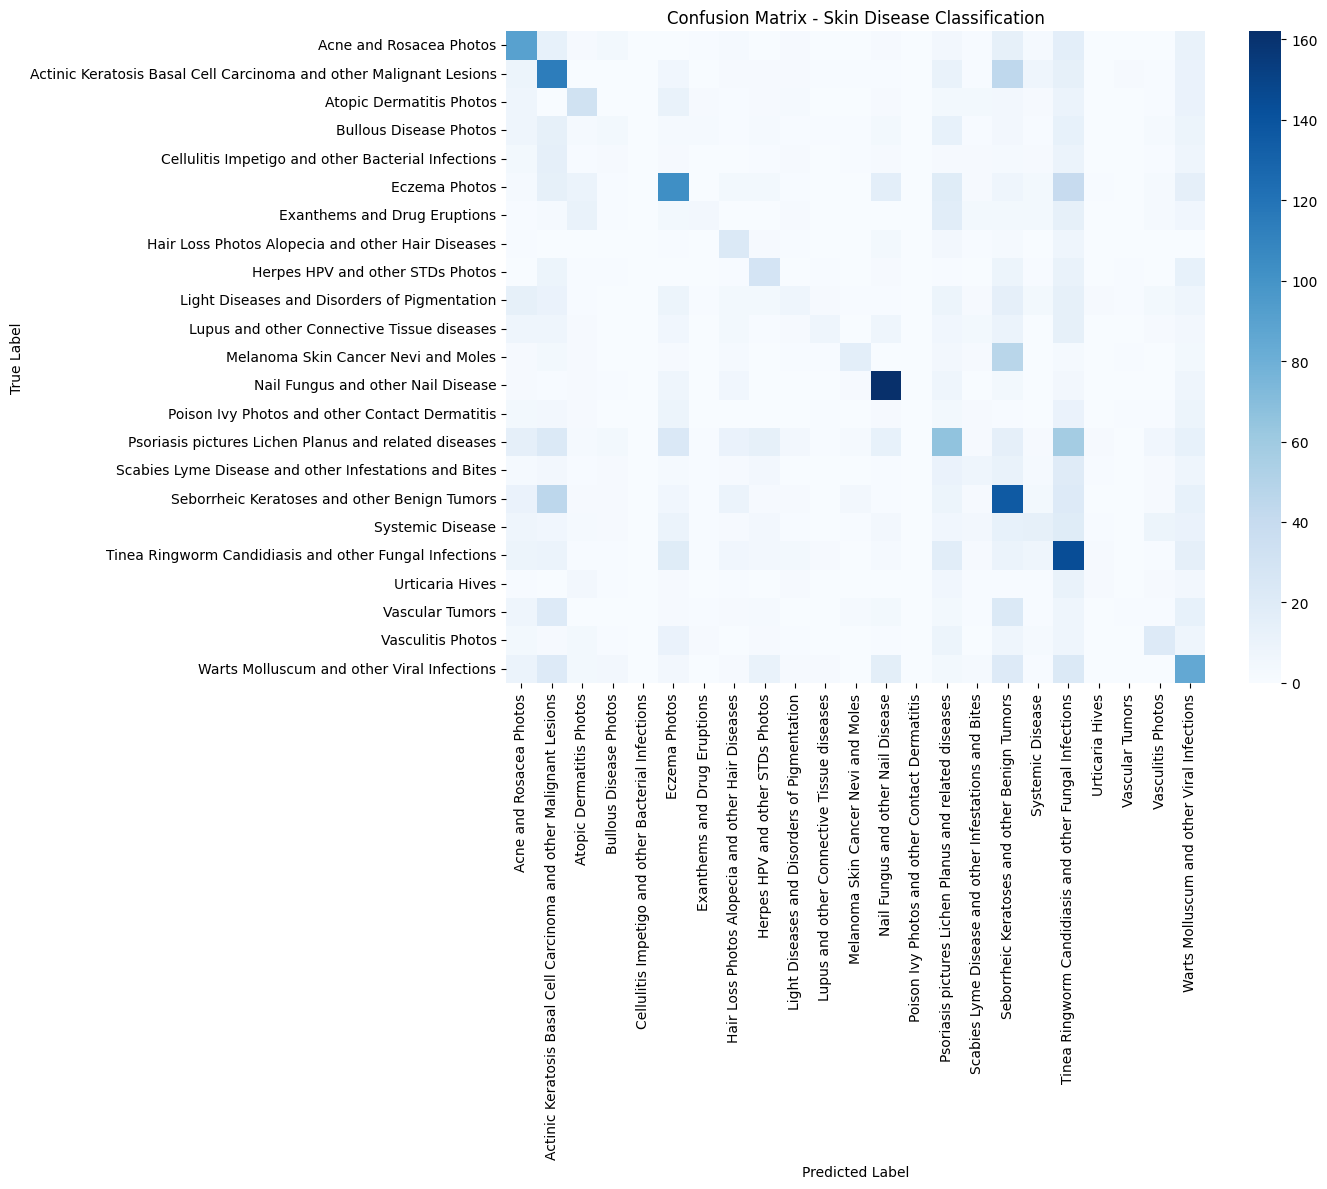

Classification Report:

                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.41      0.54      0.47       168
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.33      0.50      0.40       230
                                          Atopic Dermatitis Photos       0.34      0.33      0.34        98
                                            Bullous Disease Photos       0.12      0.04      0.07        90
                Cellulitis Impetigo and other Bacterial Infections       0.00      0.00      0.00        58
                                                     Eczema Photos       0.42      0.42      0.42       247
                                      Exanthems and Drug Eruptions       0.25      0.06      0.10        81
                 Hair Loss Photos Alopecia and other Hair Diseases       0.26      0.48      0.34        48
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_prob = global_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Skin Disease Classification')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))


accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {accuracy:.4f}")
